In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def create_boxplots_wrt_sigma(sigma_value, path, output_dir="plots"):
    """Create boxplots for a specific sigma value using efficient Polars operations.
    
    Parameters:
    -----------
    sigma_value : float
        The sigma value to filter data for
    path : str
        Path to the directory containing parquet files
    output_dir : str
        Directory to save the output plot
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all chunk files
    chunk_files = sorted([f for f in os.listdir(path) 
                         if f.startswith('combined_simulation_results_epoch') and f.endswith('.parquet')])
    
    # Process all chunks in one go using Polars
    df = pl.concat([
        pl.scan_parquet(os.path.join(path, chunk))
        .filter(pl.col('sigma') == sigma_value)
        for chunk in chunk_files
    ]).collect()
    
    # Calculate derived values using Polars expressions
    df = df.with_columns([
        (pl.col('final_x') * pl.col('final_price') + pl.col('final_y') + pl.col('fees_out')).alias('vout_dis'),
        (pl.col('final_x') * pl.col('final_price') + pl.col('final_y') + pl.col('fees_inc')).alias('vinc_dis'),
        (pl.col('final_xout') * pl.col('final_price') + pl.col('final_yout')).alias('vout_re'),
        (pl.col('final_xinc') * pl.col('final_price') + pl.col('final_yinc')).alias('vinc_re')
    ])
    
    # Calculate differences
    df = df.with_columns([
        (pl.col('vout_dis') - pl.col('vinc_dis')).alias('diff_dis_out_in'),
        (pl.col('vout_re') - pl.col('vinc_re')).alias('diff_re_out_in'),
        (pl.col('vout_dis') - pl.col('vout_re')).alias('diff_dis_out_re_out'),
        (pl.col('vinc_dis') - pl.col('vinc_re')).alias('diff_dis_in_re_in')
    ])
    
    # Convert to pandas only once for plotting
    plot_df = df.select(['gamma', 'diff_dis_out_in', 'diff_re_out_in', 
                        'diff_dis_out_re_out', 'diff_dis_in_re_in']).to_pandas()
    
    # Get unique gamma values for tick labels
    unique_gammas = sorted(plot_df['gamma'].unique())
    tick_positions = np.arange(len(unique_gammas))
    tick_labels = [f'{gamma:.3f}' if i % 3 == 0 else '' for i, gamma in enumerate(unique_gammas)]
    
    # Create the plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Differences in Values for σ = {sigma_value}', fontsize=16)
    
    # Plot 1: Distribute Out - Distribute In
    ax1 = axes[0, 0]
    sns.boxplot(data=plot_df, x='gamma', y='diff_dis_out_in', ax=ax1)
    ax1.set_title('Distribute Out - Distribute In')
    ax1.set_xlabel('Fee Rate (γ)')
    ax1.set_ylabel('Value Difference')
    ax1.grid(True, axis='y')
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 2: Rebalance Out - Rebalance In
    ax2 = axes[0, 1]
    sns.boxplot(data=plot_df, x='gamma', y='diff_re_out_in', ax=ax2)
    ax2.set_title('Rebalance Out - Rebalance In')
    ax2.set_xlabel('Fee Rate (γ)')
    ax2.set_ylabel('Value Difference')
    ax2.grid(True, axis='y')
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 3: Distribute In - Rebalance In
    ax3 = axes[1, 0]
    sns.boxplot(data=plot_df, x='gamma', y='diff_dis_in_re_in', ax=ax3)
    ax3.set_title('Distribute In - Rebalance In')
    ax3.set_xlabel('Fee Rate (γ)')
    ax3.set_ylabel('Value Difference')
    ax3.grid(True, axis='y')
    ax3.set_xticks(tick_positions)
    ax3.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 4: Distribute Out - Rebalance Out
    ax4 = axes[1, 1]
    sns.boxplot(data=plot_df, x='gamma', y='diff_dis_out_re_out', ax=ax4)
    ax4.set_title('Distribute Out - Rebalance Out')
    ax4.set_xlabel('Fee Rate (γ)')
    ax4.set_ylabel('Value Difference')
    ax4.grid(True, axis='y')
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"{output_dir}/boxplots_sigma_{sigma_value}.png", dpi=500)
    
    return fig


In [2]:
def create_boxplots_wrt_gamma(gamma_value, path, output_dir="plots"):
    """Create boxplots for a specific sigma value using efficient Polars operations.
    
    Parameters:
    -----------
    gamma_value : float
        The gamma value to filter data for
    path : str
        Path to the directory containing parquet files
    output_dir : str
        Directory to save the output plot
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all chunk files
    chunk_files = sorted([f for f in os.listdir(path) 
                         if f.startswith('combined_simulation_results_epoch') and f.endswith('.parquet')])
    
    # Process all chunks in one go using Polars
    df = pl.concat([
        pl.scan_parquet(os.path.join(path, chunk))
        .filter(pl.col('gamma') == gamma_value)
        for chunk in chunk_files
    ]).collect()
    
    # Calculate derived values using Polars expressions
    df = df.with_columns([
        (pl.col('final_x') * pl.col('final_price') + pl.col('final_y') + pl.col('fees_out')).alias('vout_dis'),
        (pl.col('final_x') * pl.col('final_price') + pl.col('final_y') + pl.col('fees_inc')).alias('vinc_dis'),
        (pl.col('final_xout') * pl.col('final_price') + pl.col('final_yout')).alias('vout_re'),
        (pl.col('final_xinc') * pl.col('final_price') + pl.col('final_yinc')).alias('vinc_re')
    ])
    
    # Calculate differences
    df = df.with_columns([
        (pl.col('vout_dis') - pl.col('vinc_dis')).alias('diff_dis_out_in'),
        (pl.col('vout_re') - pl.col('vinc_re')).alias('diff_re_out_in'),
        (pl.col('vout_dis') - pl.col('vout_re')).alias('diff_dis_out_re_out'),
        (pl.col('vinc_dis') - pl.col('vinc_re')).alias('diff_dis_in_re_in')
    ])
    
    # Convert to pandas only once for plotting
    plot_df = df.select(['sigma', 'diff_dis_out_in', 'diff_re_out_in', 
                        'diff_dis_out_re_out', 'diff_dis_in_re_in']).to_pandas()
    
    # Get unique gamma values for tick labels
    unique_sigmas = sorted(plot_df['sigma'].unique())
    tick_positions = np.arange(len(unique_sigmas))
    tick_labels = [f'{sigma:.3f}' if i % 3 == 0 else '' for i, sigma in enumerate(unique_sigmas)]
    
    # Create the plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Differences in Values for γ = {gamma_value}', fontsize=16)
    
    # Plot 1: Distribute Out - Distribute In
    ax1 = axes[0, 0]
    sns.boxplot(data=plot_df, x='sigma', y='diff_dis_out_in', ax=ax1)
    ax1.set_title('Distribute Out - Distribute In')
    ax1.set_xlabel('sigma (σ)')
    ax1.set_ylabel('Value Difference')
    ax1.grid(True, axis='y')
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 2: Rebalance Out - Rebalance In
    ax2 = axes[0, 1]
    sns.boxplot(data=plot_df, x='sigma', y='diff_re_out_in', ax=ax2)
    ax2.set_title('Rebalance Out - Rebalance In')
    ax2.set_xlabel('sigma (σ)')
    ax2.set_ylabel('Value Difference')
    ax2.grid(True, axis='y')
    ax2.set_xticks(tick_positions)
    ax2.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 3: Distribute In - Rebalance In
    ax3 = axes[1, 0]
    sns.boxplot(data=plot_df, x='sigma', y='diff_dis_in_re_in', ax=ax3)
    ax3.set_title('Distribute In - Rebalance In')
    ax3.set_xlabel('sigma (σ)')
    ax3.set_ylabel('Value Difference')
    ax3.grid(True, axis='y')
    ax3.set_xticks(tick_positions)
    ax3.set_xticklabels(tick_labels, rotation=45)
    
    # Plot 4: Distribute Out - Rebalance Out
    ax4 = axes[1, 1]
    sns.boxplot(data=plot_df, x='sigma', y='diff_dis_out_re_out', ax=ax4)
    ax4.set_title('Distribute Out - Rebalance Out')
    ax4.set_xlabel('sigma (σ)')
    ax4.set_ylabel('Value Difference')
    ax4.grid(True, axis='y')
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f"{output_dir}/boxplots_sigma_{gamma_value}.png", dpi=500)
    
    return fig


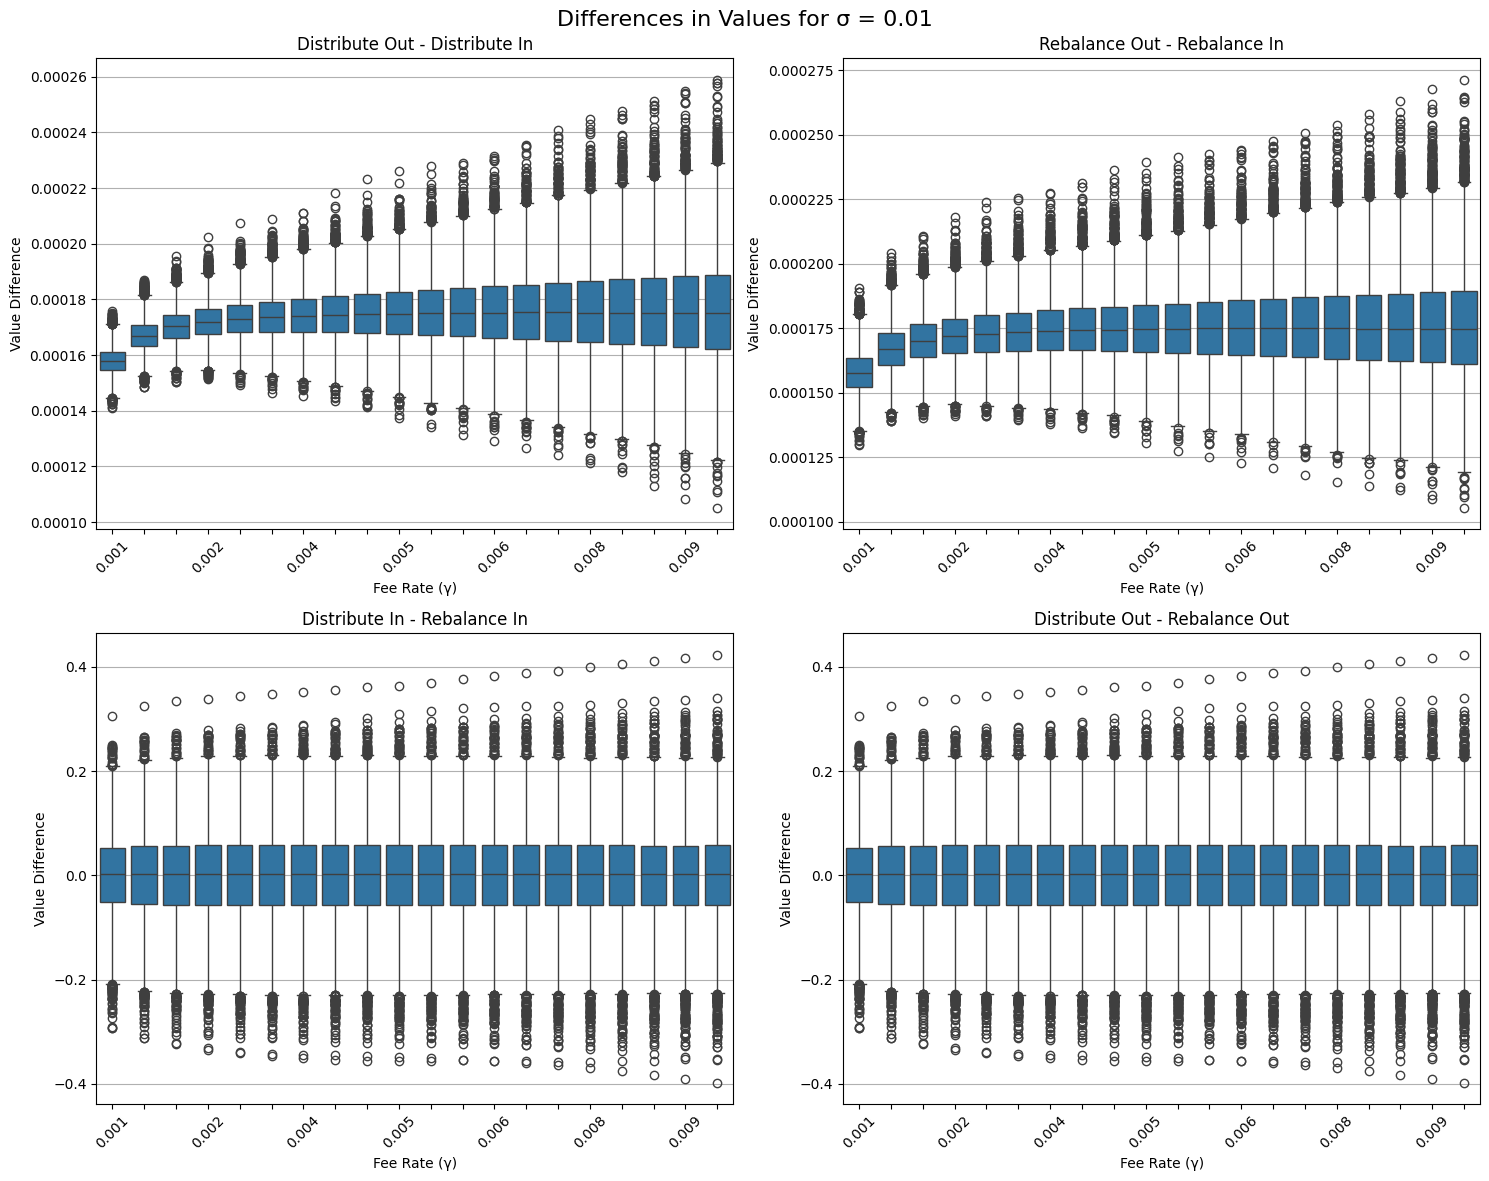

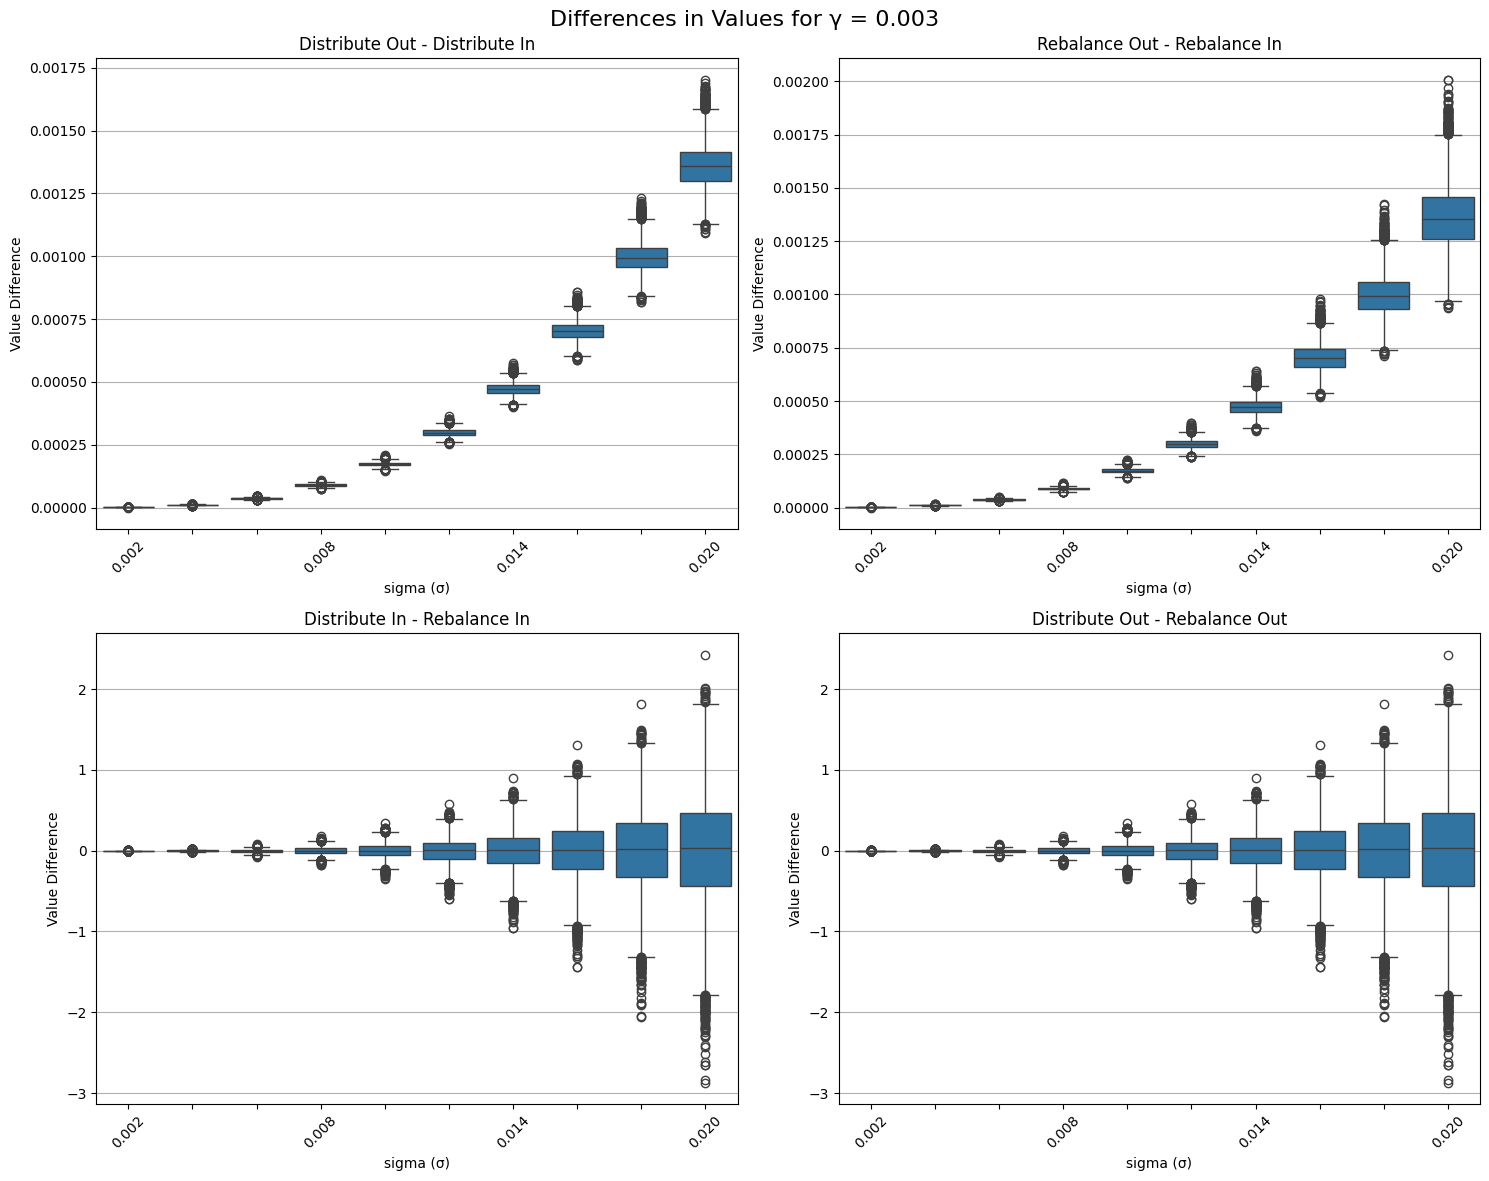

In [3]:

path = '/home/shiftpub/Dynamic_AMM/inf_step_exp/mc_approach/jit_simulation_results/20250412_192818'
sigma_value = 0.01  # Change this to your desired sigma value
fig = create_boxplots_wrt_sigma(sigma_value, path)
plt.show()

gamma_value = 0.003  # Change this to your desired sigma value
fig = create_boxplots_wrt_gamma(gamma_value, path)
plt.show()